In [ ]:
!pip install transformers evaluate

In [ ]:
import pandas as pd
import os
import numpy as np
import torch
import evaluate

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset

############################ FILE PATHS ########################################
DATA_PATH = "/content/teknofest_preprocessed_data_5fold.csv"
TEST_FOLD = 4
VALID_FOLD = 3

############################## PARAMS ##########################################
MAX_LENGTH = 32
#MODEL_NAME = "dbmdz/bert-base-turkish-uncased" # since the text is lowercased.
#MODEL_NAME = "dbmdz/bert-base-turkish-128k-uncased"
#MODEL_NAME = "dbmdz/convbert-base-turkish-mc4-uncased"
MODEL_NAME = "emrecan/bert-base-turkish-cased-mean-nli-stsb-tr"
#MODEL_NAME = "burakaytan/roberta-base-turkish-uncased"
#MODEL_NAME = "dbmdz/electra-base-turkish-cased-discriminator"
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 64
NUM_TRAIN_EPOCHS = 5
WEIGHT_DECAY = 0.01
DEVICE = "cuda"
SEED = 2023
EVALUATION_STRATEGY = "epoch"
SAVE_STRATEGY = "epoch"
LEARNING_RATE = 1e-5
OUTPUT_DIR = "bert-base-turkish-cased-mean-nli-stsb-tr-5fold-32maxl-32tb-64vb-5ep-001wd-1e5lr-3validfold-4testfold-corrected-misslabels"

########################### UTILITY ############################################


class ProfanityDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy":accuracy.compute(predictions=predictions, references=labels),
            "f1_score":f1.compute(predictions=predictions, references=labels, average="macro")
      }

set_seed(SEED)

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


In [ ]:
all_df = pd.read_csv(DATA_PATH)

In [ ]:
train_df = all_df[~all_df.kfold.isin([TEST_FOLD, VALID_FOLD])]
val_df = all_df[all_df.kfold.isin([VALID_FOLD])]
test_df = all_df[all_df.kfold.isin([TEST_FOLD])]

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((7477, 5), (2492, 5), (2492, 5))

In [ ]:
train_df.sample()

,id,text,is_offensive,target,kfold
8285,2447b26b-4370-4928-b151-5df76ae1b738,siktir boktan işlere girmemek lazım,1,PROFANITY,2


In [ ]:
train_misslabeled = pd.read_excel("train_misslabeled_fixed.xlsx")
train_misslabeled.drop(columns=["label","score"], inplace=True)
train_misslabeled.rename(columns={"gold":"target"}, inplace=True)
train_misslabeled

,text,target,corrected_label
0,adamın son iki harfisin,PROFANITY,DELETED
1,elinin hamuruyla işi becerebilir misin,SEXIST,SEXIST
2,üzerindeki elbiseyi kızılay dağıttı,INSULT,INSULT
3,ermeni yapıları var burada,OTHER,OTHER
4,kadar kabullenmesen iş böyle yapılır,OTHER,OTHER
...,...,...,...
137,hayvan diyorum yarısı hayvandı adı eskiden anı...,OTHER,DELETED
138,istanbulda kadına çocuğa hayvana şiddet sokağa...,OTHER,OTHER
139,yanlarında ermeni papaz vardır,OTHER,OTHER
140,kadın dindar tatlı dilli artık onun güzelliğin...,OTHER,OTHER


In [ ]:
train_df = train_df.merge(train_misslabeled, on=["text","target"],how="left")

In [ ]:
train_df.loc[~train_df['corrected_label'].isna(), 'target'] = train_df.loc[~train_df['corrected_label'].isna(), 'corrected_label']

In [ ]:
train_df.target.value_counts()

OTHER        2147
INSULT       1438
PROFANITY    1419
SEXIST       1245
RACIST       1221
DELETED         7
Name: target, dtype: int64

In [ ]:
train_df = train_df[train_df.target != "DELETED"]

In [ ]:
train_df.shape

(7470, 6)

In [ ]:
#external_data = pd.read_excel("/content/postprocessed_data.xlsx", usecols=["translated_text","new_target"])
#external_data = external_data[external_data.new_target != "None"]
#external_data.rename(columns={"translated_text":"text","new_target":"target"}, inplace=True)

In [ ]:
#external_data["text_token_length"] = external_data['text'].apply(lambda x:len(tokenizer(x)['input_ids']))

Token indices sequence length is longer than the specified maximum sequence length for this model (1512 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
#external_data = external_data[external_data.text_token_length < 40]

In [ ]:
#train_df = pd.concat([train_df[["text","target"]], external_data]).sample(frac=1)

In [ ]:
label2id = {label:id for id, label in enumerate(train_df['target'].unique())}
id2label = {id:label for label,id in label2id.items()}

In [ ]:
label2id, id2label

({'INSULT': 0, 'RACIST': 1, 'SEXIST': 2, 'PROFANITY': 3, 'OTHER': 4},
 {0: 'INSULT', 1: 'RACIST', 2: 'SEXIST', 3: 'PROFANITY', 4: 'OTHER'})

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, 
                                                           num_labels = len(label2id), #TODO EDIT HERE
                                                           label2id=label2id, 
                                                           id2label=id2label
                                                           )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emrecan/bert-base-turkish-cased-mean-nli-stsb-tr and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_df['token_length'] = train_df['text'].apply(lambda x:len(tokenizer(x)['input_ids']))
train_df['token_length'].min(),train_df['token_length'].max(),train_df['token_length'].mean()

(3, 52, 10.046586345381526)

In [ ]:
train_df.target.value_counts()

OTHER        2147
INSULT       1438
PROFANITY    1419
SEXIST       1245
RACIST       1221
Name: target, dtype: int64

In [ ]:
val_df['token_length'] = val_df['text'].apply(lambda x:len(tokenizer(x)['input_ids']))
val_df['token_length'].min(),val_df['token_length'].max(),val_df['token_length'].mean()

<ipython-input-78-09633e61e373>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['token_length'] = val_df['text'].apply(lambda x:len(tokenizer(x)['input_ids']))


(3, 52, 10.123194221508829)

In [ ]:
test_df['token_length'] = test_df['text'].apply(lambda x:len(tokenizer(x)['input_ids']))
test_df['token_length'].min(),test_df['token_length'].max(),test_df['token_length'].mean()

<ipython-input-79-6bf1192df5d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['token_length'] = test_df['text'].apply(lambda x:len(tokenizer(x)['input_ids']))


(4, 42, 10.01725521669342)

In [ ]:
# 32 tokendan büyük çok az data var ve bu dataların yüzde 95'i Other class'ına ait o yüzden max lengthi  32 yapabiliriz.
train_df[train_df['token_length'] > 32].shape, val_df[val_df['token_length'] > 32].shape,test_df[test_df['token_length'] > 32].shape

((10, 7), (5, 6), (4, 6))

In [ ]:
bugün dışarı cıkıcaktım -> 3 kelime
bugün dışar ı çıkacak tım -> 5 token

array([[<Axes: title={'center': 'token_length'}>]], dtype=object)

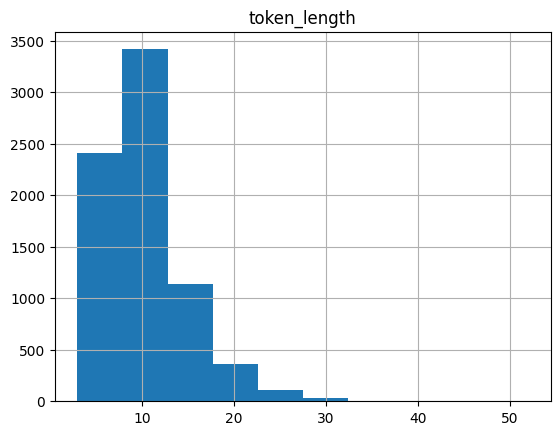

In [ ]:
train_df.hist('token_length')

In [ ]:
train_df['target'] = train_df['target'].map(label2id)
val_df['target'] = val_df['target'].map(label2id)
test_df['target'] = test_df['target'].map(label2id)

<ipython-input-82-db807c48cac0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['target'] = val_df['target'].map(label2id)
<ipython-input-82-db807c48cac0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'] = test_df['target'].map(label2id)


In [ ]:
train_encodings = tokenizer(train_df["text"].values.tolist(), 
                            truncation=True, 
                            padding=True, 
                            max_length= MAX_LENGTH
                            )
valid_encodings = tokenizer(val_df["text"].values.tolist(), 
                            truncation=True, 
                            padding=True, 
                            max_length= MAX_LENGTH)

train_labels = train_df["target"].values.tolist()
valid_labels = val_df["target"].values.tolist()

# convert our tokenized data into a torch Dataset
train_dataset = ProfanityDataset(train_encodings, train_labels)
valid_dataset = ProfanityDataset(valid_encodings, valid_labels)

In [ ]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy = EVALUATION_STRATEGY,
    save_strategy = SAVE_STRATEGY,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VALID_BATCH_SIZE,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,No log,0.265118,{'accuracy': 0.9141252006420546},{'f1': 0.9157756119089097}
2,No log,0.234463,{'accuracy': 0.9273675762439807},{'f1': 0.9280518888983413}
3,0.393300,0.233147,{'accuracy': 0.9297752808988764},{'f1': 0.9299961054571}
4,0.393300,0.243414,{'accuracy': 0.9337881219903692},{'f1': 0.934396005609073}
5,0.122200,0.248097,{'accuracy': 0.9333868378812199},{'f1': 0.9339960898385625}


Trainer is attempting to log a value of "{'accuracy': 0.9141252006420546}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9157756119089097}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9273675762439807}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9280518888983413}" of type <class 'dict'> for key "eval/f1_score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9297752808988764}" of type <clas

TrainOutput(global_step=1170, training_loss=0.23225722109150682, metrics={'train_runtime': 268.6745, 'train_samples_per_second': 139.016, 'train_steps_per_second': 4.355, 'total_flos': 614216413814400.0, 'train_loss': 0.23225722109150682, 'epoch': 5.0})

# Test Predictions

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model="/content/bert-base-turkish-cased-mean-nli-stsb-tr-5fold-32maxl-32tb-64vb-5ep-001wd-1e5lr-3validfold-4testfold-corrected-misslabels/checkpoint-1170")

In [ ]:
from tqdm import tqdm

predictions = []
for text in tqdm(test_df['text']):
  response = classifier(text)
  predictions.append([response[0]['label'],response[0]['score']])

100%|██████████| 2492/2492 [05:02<00:00,  8.25it/s]


In [ ]:
predictions_df = pd.DataFrame(predictions, columns=["label","score"])
predictions_df['text'] = test_df['text'].tolist()
predictions_df['gold'] = test_df['target'].tolist()
predictions_df['gold'] = predictions_df['gold'].map(id2label)

predictions_df = predictions_df[["text","gold","label","score"]]

In [ ]:
predictions_df

,text,gold,label,score
0,kadın yönetici sayısı oldukça olduğu şirket iy...,SEXIST,SEXIST,0.989058
1,suriyeliler yozlaşıp toplumda huzuru bozuyorlar,RACIST,RACIST,0.995732
2,kadar terbiyesizsin,INSULT,INSULT,0.995117
3,özsaygısı düşük birisin,INSULT,INSULT,0.994172
4,köpek havlayıp duruyorsun,INSULT,INSULT,0.993793
...,...,...,...,...
2487,ermenilerin böyle sorunu var,OTHER,RACIST,0.989785
2488,nedenle kendi çıkarımız avrupalılar türkiyeyi ...,OTHER,OTHER,0.972791
2489,hiçbir tane mi ceren gözlü kürt kızı yok,OTHER,RACIST,0.994580
2490,hayalleri gerçek etmek birisinin delilik yapma...,OTHER,OTHER,0.930539


In [ ]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

gold = predictions_df['gold'].tolist()
preds = predictions_df['label'].tolist()

print("Accuracy score: ", accuracy_score(gold,preds))
print("f1_score score: ", f1_score(gold,preds, average="macro"))

Accuracy score:  0.930577849117175
f1_score score:  0.9318060172396267


In [ ]:
print(classification_report(gold, preds, target_names = label2id.keys()))

              precision    recall  f1-score   support

      INSULT       0.87      0.87      0.87       478
      RACIST       0.95      0.91      0.93       716
      SEXIST       0.96      0.93      0.94       475
   PROFANITY       0.93      0.97      0.95       407
       OTHER       0.94      0.98      0.96       416

    accuracy                           0.93      2492
   macro avg       0.93      0.93      0.93      2492
weighted avg       0.93      0.93      0.93      2492



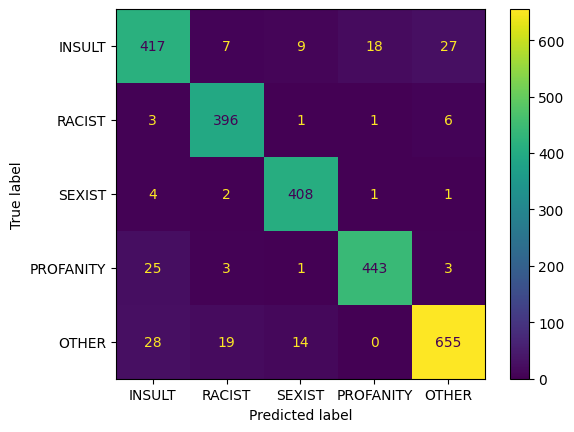

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(gold, preds, labels = list(label2id.keys()))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(label2id.keys()))
disp.plot()

In [ ]:
predictions_df[(predictions_df.gold !=predictions_df.label)]

,text,gold,label,score
6,olun hayatınıza birden bire giren mallara prim...,INSULT,OTHER,0.842794
20,ırkçılık almanyada gelişti,RACIST,OTHER,0.787027
24,bulgar göçmenleri buraya alışverişe gelir,OTHER,RACIST,0.751093
55,koca karı ilacını denemelisin,OTHER,SEXIST,0.996928
64,varos hareketlerinden vazgec,INSULT,OTHER,0.616574
...,...,...,...,...
2482,eş aileden gelen maddi kazanım mal vs olabilir,OTHER,SEXIST,0.699688
2484,kadınlar durmadan masaları dolaşıyordu,OTHER,SEXIST,0.990241
2486,taraf profesyonel hırsız diğer çete beceriksiz,OTHER,INSULT,0.607597
2487,ermenilerin böyle sorunu var,OTHER,RACIST,0.989785


In [ ]:
predictions_df[(predictions_df.gold !=predictions_df.label)].to_excel("test_misspredictions_v2.xlsx", index=False)

In [ ]:
pd.read_csv("mispredicted_text.csv")

,text
0,sana bi istavrozunu şaşırtırım kırk yıl kendin...
1,siz kadınlar böyle karaktersiz. adamlarda bulu...
2,sevişti bir bakir bir bakire; erkeğe milli ded...
3,i̇ngiliz boku yiyen aç pezevenk


In [ ]:
an= 0
for an, (idx, row) in enumerate(predictions_df[(predictions_df.gold !=predictions_df.label)].iterrows()):
  an+=1
  print("Gold: ",row['gold'])
  print("Predicted: ", row['label'])
  print("Score: ", row['score'])
  print("Text: ", row['text'])

  print("*"*100)
  print("\n")

In [ ]:
len(predictions_df)

2492

In [ ]:
an/len(predictions_df)

0.06982343499197431

Gold:  OTHER
Predicted:  SEXIST
Score:  0.8652151823043823
Text:  geldim ana oldu
****************************************************************************************************

Gold:  RACIST
Predicted:  INSULT
Score:  0.9915888905525208
Text:  sana bi istavrozunu şaşırtırım kırk yıl kendine gelemezsin
****************************************************************************************************

Gold:  RACIST
Predicted:  OTHER
Score:  0.5220296382904053
Text:  atletizim şampiyonasında siyahiler altın madalya kazanmaya devam ediyor
****************************************************************************************************

Gold:  INSULT
Predicted:  SEXIST
Score:  0.9952901601791382
Text:  siz kadınlar böyle karaktersiz. adamlarda buluyorsunuz anlamıyorum doğrusu
****************************************************************************************************

Gold:  RACIST
Predicted:  OTHER
Score:  0.9514945149421692
Text:  safkan= değilim-
****************************************************************************************************

Gold:  PROFANITY
Predicted:  SEXIST
Score:  0.5165250301361084
Text:  fahişe eşittir seks emekçisidir
****************************************************************************************************
Gold:  INSULT
Predicted:  OTHER
Score:  0.9668828845024109
Text:  yapamayacağını biliyordum
****************************************************************************************************
Gold:  OTHER
Predicted:  RACIST
Score:  0.9836679100990295
Text:  kızılelma senden sorulur kuzgunlar hangi leşe giderse gitsin türk hakanın devleti başa gelecek önderi olduğun hareket asla engellenemeyecek
****************************************************************************************************
Gold:  OTHER
Predicted:  SEXIST
Score:  0.9700849652290344
Text:  birinci emelleri oğullarına yahut kardeşlerine çirkin bir kız almaktır
****************************************************************************************************
Gold:  PROFANITY
Predicted:  SEXIST
Score:  0.9711324572563171
Text:  sevişti bir bakir bir bakire; erkeğe milli dediler kıza fahişe
****************************************************************************************************
Gold:  PROFANITY
Predicted:  INSULT
Score:  0.992343008518219
Text:  başlarım babanın şarap çanağından
****************************************************************************************************


Gold:  INSULT
Predicted:  OTHER
Score:  0.9898399114608765
Text:  ağlamak işin kolayına kaçmaktır
****************************************************************************************************
Gold:  PROFANITY
Predicted:  RACIST
Score:  0.991144597530365
Text:  i̇ngiliz boku yiyen aç pezevenk
****************************************************************************************************

In [ ]:
!ls

sample_data
teknofest_model_maxlen32_removedpunct_removed_other
teknofest_preprocessed_test_df.csv
teknofest_preprocessed_train_df.csv
teknofest_preprocessed_val_df.csv


In [ ]:
!rm teknofest_model_maxlen32_removedpunct_removed_other/checkpoint-1115/optimizer.pt

In [ ]:
!tar -czvf teknofest_model_maxlen32_removedpunct_removed_other.tar.gz teknofest_model_maxlen32_removedpunct_removed_other/checkpoint-1115/*

teknofest_model_maxlen32_removedpunct_removed_other/checkpoint-1115/config.json
teknofest_model_maxlen32_removedpunct_removed_other/checkpoint-1115/pytorch_model.bin
teknofest_model_maxlen32_removedpunct_removed_other/checkpoint-1115/rng_state.pth
teknofest_model_maxlen32_removedpunct_removed_other/checkpoint-1115/scheduler.pt
teknofest_model_maxlen32_removedpunct_removed_other/checkpoint-1115/special_tokens_map.json
teknofest_model_maxlen32_removedpunct_removed_other/checkpoint-1115/tokenizer_config.json
teknofest_model_maxlen32_removedpunct_removed_other/checkpoint-1115/tokenizer.json
teknofest_model_maxlen32_removedpunct_removed_other/checkpoint-1115/trainer_state.json
teknofest_model_maxlen32_removedpunct_removed_other/checkpoint-1115/training_args.bin
teknofest_model_maxlen32_removedpunct_removed_other/checkpoint-1115/vocab.txt


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!mkdir /content/gdrive/MyDrive/teknofest-multiclass-model

In [ ]:
!mv teknofest_model_maxlen32_removedpunct_removed_other.tar.gz /content/gdrive/MyDrive/teknofest-multiclass-model/

In [ ]:
!cp -r /content/bert-base-turkish-cased-mean-nli-stsb-tr-5fold-32maxl-32tb-64vb-5ep-001wd-1e5lr-3validfold-4testfold-corrected-misslabels/checkpoint-1170/* /content/gdrive/MyDrive/teknofest-multiclass-model/bert-base-turkish-cased-mean-nli-stsb-tr-5fold-32maxl-32tb-64vb-5ep-001wd-1e5lr-3validfold-4testfold-corrected-misslabels/

In [ ]:
[res['label'] for res in classifier(test_df["text"].tolist()[:5])]

['SEXIST', 'RACIST', 'INSULT', 'INSULT', 'INSULT']

In [ ]:
# Train Predictions

In [ ]:
from tqdm import tqdm

tr_predictions = []
for idx, text in enumerate(tqdm(train_df['text'])):

  response = classifier(text)
  tr_predictions.append([response[0]['label'],response[0]['score']])

100%|██████████| 7477/7477 [15:19<00:00,  8.13it/s]


In [ ]:
predictions_df_train = pd.DataFrame(tr_predictions, columns=["label","score"])
predictions_df_train['text'] = train_df['text'].tolist()
predictions_df_train['gold'] = train_df['target'].tolist()
predictions_df_train['gold'] = predictions_df_train['gold'].map(id2label)

predictions_df_train = predictions_df_train[["text","gold","label","score"]]

In [ ]:
gold_tr= predictions_df_train['gold'].tolist()
preds_tr = predictions_df_train['label'].tolist()

print("Accuracy score: ", accuracy_score(gold_tr,preds_tr))
print("f1_score score: ", f1_score(gold_tr,preds_tr, average="macro"))

Accuracy score:  0.9810084258392403
f1_score score:  0.9808138570987758


In [ ]:
predictions_df_train[(predictions_df_train.gold !=predictions_df_train.label)].to_excel("train_misslabeled.xlsx", index=False)

In [ ]:
# Valid Predictions

In [ ]:
from tqdm import tqdm

val_predictions = []
for text in tqdm(val_df['text']):
  response = classifier(text)
  val_predictions.append([response[0]['label'],response[0]['score']])

100%|██████████| 2492/2492 [04:49<00:00,  8.62it/s]


In [ ]:
predictions_df_valid = pd.DataFrame(val_predictions, columns=["label","score"])
predictions_df_valid['text'] = val_df['text'].tolist()
predictions_df_valid['gold'] = val_df['target'].tolist()
predictions_df_valid['gold'] = predictions_df_valid['gold'].map(id2label)

predictions_df_valid = predictions_df_valid[["text","gold","label","score"]]

In [ ]:
predictions_df_valid

,text,gold,label,score
0,işe yaramaz herif,INSULT,INSULT,0.992028
1,ananın amına ceviz sokayım,PROFANITY,PROFANITY,0.995899
2,kasaba muhtaç olacağıma sikimi keser onu yerim,PROFANITY,PROFANITY,0.995432
3,ancak bana geri dönmediler,OTHER,OTHER,0.997616
4,özellikle büyük şehirlere aynı gün içinde deği...,OTHER,OTHER,0.996871
...,...,...,...,...
2487,kısa mevzu derinliğinden sonra tilki gel abici...,OTHER,INSULT,0.923799
2488,suriyeli kızın ölmeden önce bıraktığı not herk...,OTHER,RACIST,0.560572
2489,yaşlı adam tepine tepine çıkışıyordu,OTHER,OTHER,0.973257
2490,komşum kendi köpeklerini bile mayanın gözü önü...,OTHER,RACIST,0.597353


In [ ]:
gold_valid = predictions_df['gold'].tolist()
preds_valid = predictions_df['label'].tolist()

print("Accuracy score: ", accuracy_score(gold_valid,preds_valid))
print("f1_score score: ", f1_score(gold_valid,preds_valid, average="macro"))

Accuracy score:  0.9301765650080257
f1_score score:  0.9311650378112992
